In [10]:
import time 
import os 
import django
import json 
from tqdm import tqdm 
import requests
from django.db import transaction
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "experiments.settings")
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

django.setup()
from core.models import SearchFile



In [2]:
import tensorflow_hub as hub
import numpy as np
import tensorflow as tf 


module = hub.load('https://tfhub.dev/google/universal-sentence-encoder-qa/3')
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

def encode_questions(questions):
    question_embeddings = module.signatures['question_encoder'](
                tf.constant(questions))
    return question_embeddings['outputs'].numpy()

def encode_responses(responses):
    response_embeddings = module.signatures['response_encoder'](
            input=tf.constant(responses),
            context=tf.constant(responses))
    return response_embeddings['outputs'].numpy()

def encode_use(sentences):
    return embed(sentences).numpy()

In [81]:
item = SearchFile.objects.get(id='3100bf0f-72c6-4cf3-bb38-2dad4edf749a')
page_data = item.parsed_data['pages']['5']

In [4]:
text = "\n".join([i.get("text", '') for i in page_data])

In [84]:
import torch 
import numpy as np
import tensorflow as tf
from transformers import BertForQuestionAnswering
from transformers import BertTokenizer

model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

def answer_question(question, answer_text):
    '''
    Takes a `question` string and an `answer_text` string (which contains the
    answer), and identifies the words within the `answer_text` that are the
    answer. Prints them out.
    '''
    # ======== Tokenize ========
    # Apply the tokenizer to the input text, treating them as a text-pair.
    input = tokenizer([(question, answer_text)], return_tensors='pt')

    # Report how long the input sequence is.

    start_scores, end_scores = model(**input) # The segment IDs to differentiate question from answer_text

    # ======== Reconstruct Answer ========
    # Find the tokens with the highest `start` and `end` scores.
    answer_start = torch.argmax(start_scores)
    answer_end = torch.argmax(end_scores)
    score =  torch.max(start_scores) + torch.max(end_scores)

    # Get the string versions of the input tokens.
    tokens = tokenizer.convert_ids_to_tokens(input['input_ids'][0])

    # Start with the first token.
    answer = tokens[answer_start]

    # Select the remaining answer tokens and join them with whitespace.
    for i in range(answer_start + 1, answer_end + 1):
        
        # If it's a subword token, then recombine it with the previous token.
        if tokens[i][0:2] == '##':
            answer += tokens[i][2:]
        
        # Otherwise, add a space then the token.
        else:
            answer += ' ' + tokens[i]
    return (score.detach().numpy(), answer)



In [85]:
from nltk import sent_tokenize

In [86]:
sentences = sent_tokenize(text)

In [87]:
from nltk import sent_tokenize
k = 5
stride = 2

import colorsys

def get_color(values):
    max_val = max(values)
    rgb = [colorsys.hsv_to_rgb(i / max_val, 1.0, 1.0) for i in values]
    return ['rgb({}, {}, {}, 0.2)'.format(int(255*x[0]), int(255*x[1]), int(255*x[2])) for x in rgb]
    
def extract_answer(question, parsed_data):
    sentences = [] 
    current_line = ""
    current_index = []
    k = 5 
    stride = 2

    all_lines = parsed_data['lines']
    for idx, line in  enumerate(all_lines): 
        text =  line["text"].replace("\n", " ")
        temp = sent_tokenize(text)
        if len(temp) == 0: 
            continue
        if len(temp) == 1:
            current_line += text + " "
            current_index.append(idx)
        else:
            current_line += temp[0] 
            current_index.append(idx)
            sentences.append({"text": current_line, "line_index": current_index})

            for i in temp[1: -1]:
                sentences.append({"text": i, "line_index": [idx]})
            current_line = temp[-1] + " "
            current_index = [idx]

    if current_line:
        sentences.append({"text": current_line, "line_index": current_index})

    contexts = [] 
    for idx in range(0, max(len(sentences) - k, 1), stride): 
        valid_sentences = sentences[idx: idx + k]
        context = {"text" : " ".join([i["text"] for i in valid_sentences])}
        line_idx = [] 
        for i in valid_sentences: 
            line_idx.extend(i['line_index'])
        context["rects"] = [{'y0': all_lines[i]['y0'], 
                             'y1': all_lines[i]['y1'], 
                             'x0': all_lines[i]['x0'], 
                             'x1': all_lines[i]['x1'], 
                             'top': all_lines[i]['top']} for i in line_idx]
        contexts.append(context)
    
    best_answer = [] 
    for context in contexts:
        answer =  answer_question(question, context["text"])
        context["score"] = float(answer[0])
        context["answer_text"] = answer[1]
    
    colors = get_color([i['score'] for i in contexts])
    for idx in range(len(contexts)): 
        contexts[idx]['color'] = colors[idx]

    return contexts


In [88]:
%%time
extract_answer("How many privilege leaves does one get?", page_data)

CPU times: user 32.8 s, sys: 4.36 s, total: 37.2 s
Wall time: 7.23 s


[{'text': 'Leave Policy – India Special Day Off Employees will be eligible to 1 day holiday as Special Day Off. This is to enable the employee to celebrate any special occasion. (The 1 day of special day off is included in the total holidays of 12 days mentioned above) This can be taken once in a calendar year. A leave application has to be made to be able to avail this Special Day off. This is a self-approved leave.',
  'rects': [{'y0': 785.632,
    'y1': 793.173,
    'x0': 455.14,
    'x1': 529.015,
    'top': 48.50699999999995},
   {'y0': 745.608,
    'y1': 754.951,
    'x0': 126.02,
    'x1': 202.139,
    'top': 86.72899999999993},
   {'y0': 723.528,
    'y1': 732.871,
    'x0': 126.02,
    'x1': 541.79,
    'top': 108.80899999999997},
   {'y0': 723.528,
    'y1': 732.871,
    'x0': 126.02,
    'x1': 541.79,
    'top': 108.80899999999997},
   {'y0': 707.568, 'y1': 716.911, 'x0': 126.02, 'x1': 523.806, 'top': 124.769},
   {'y0': 707.568, 'y1': 716.911, 'x0': 126.02, 'x1': 523.806, '

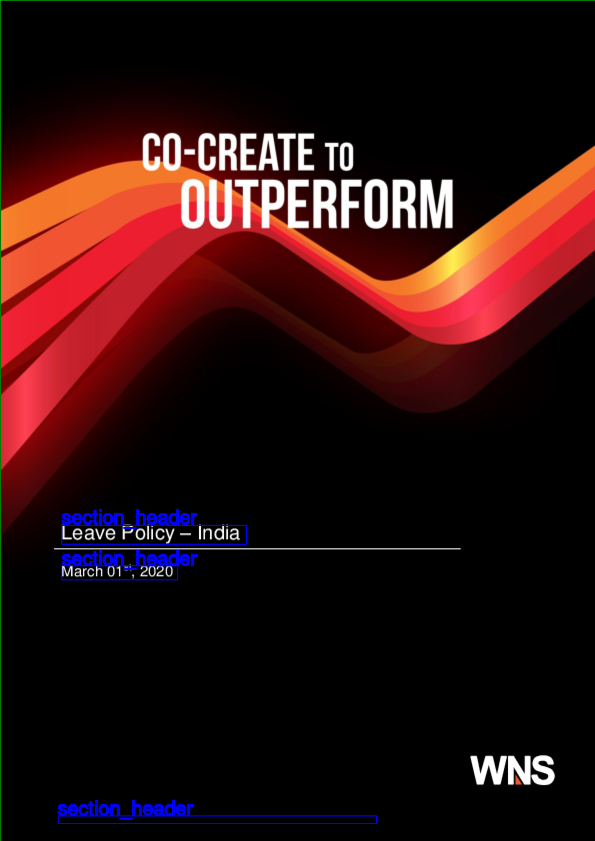

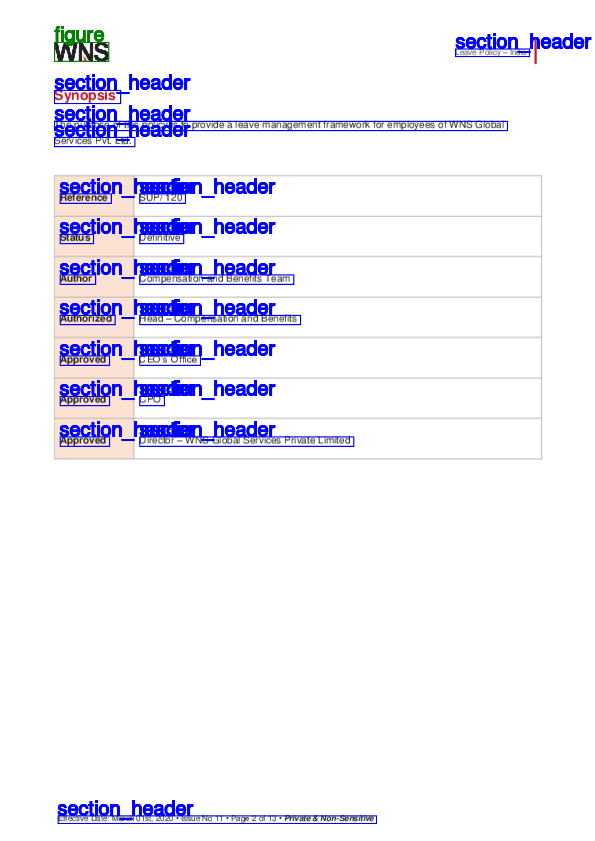

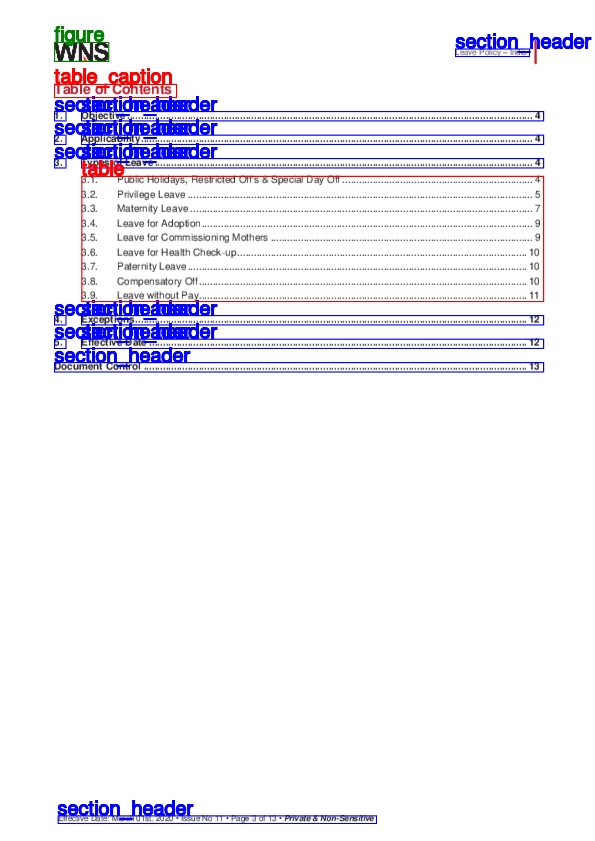

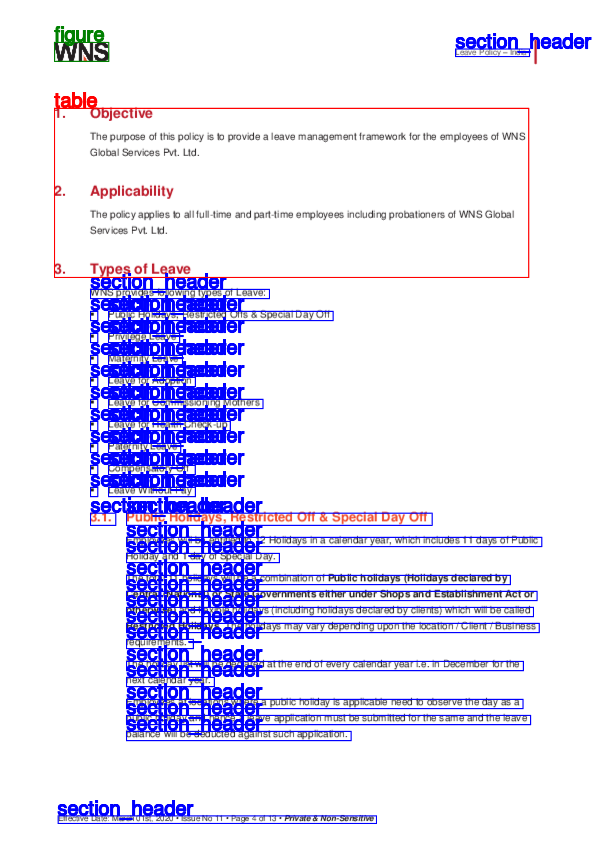

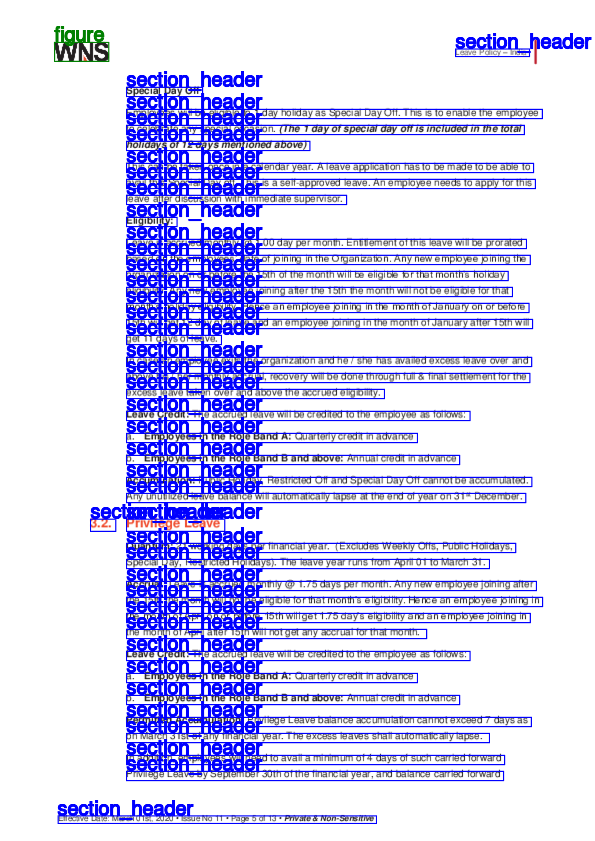

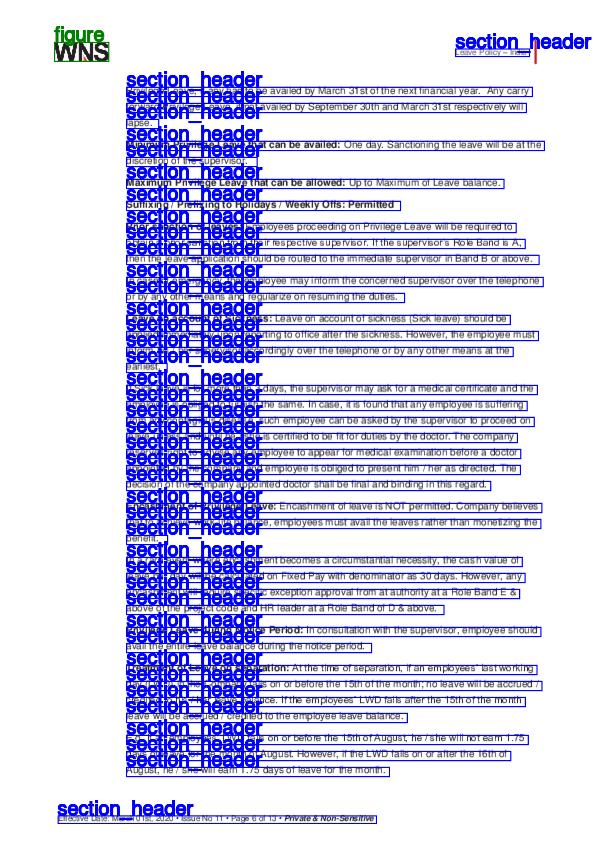

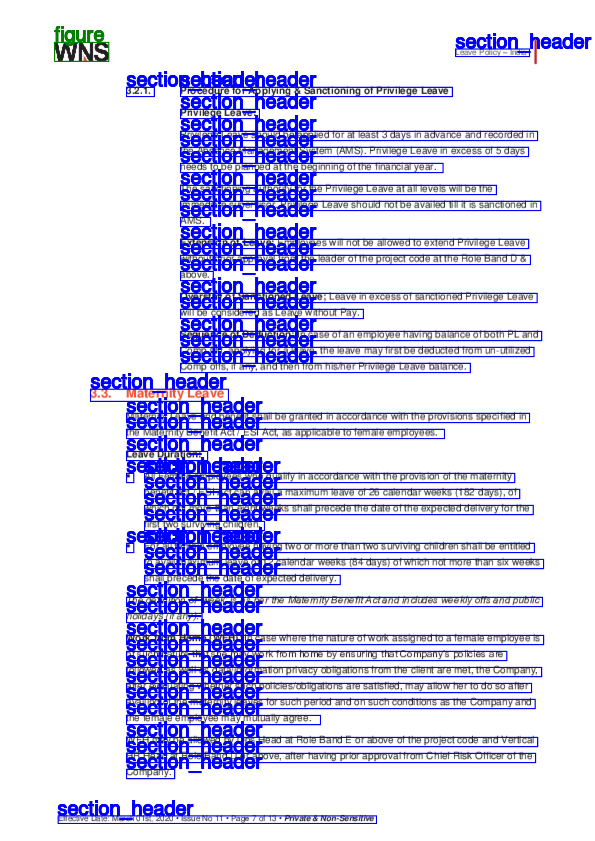

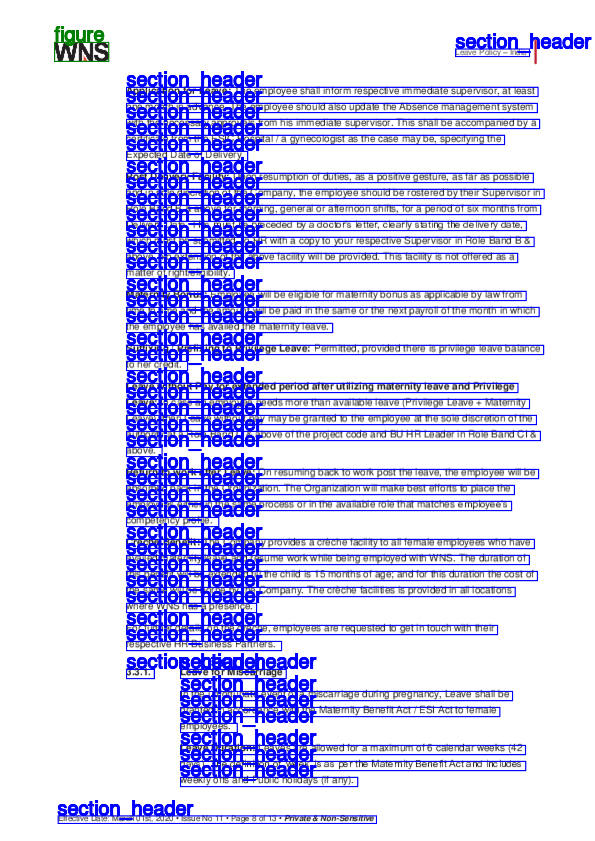

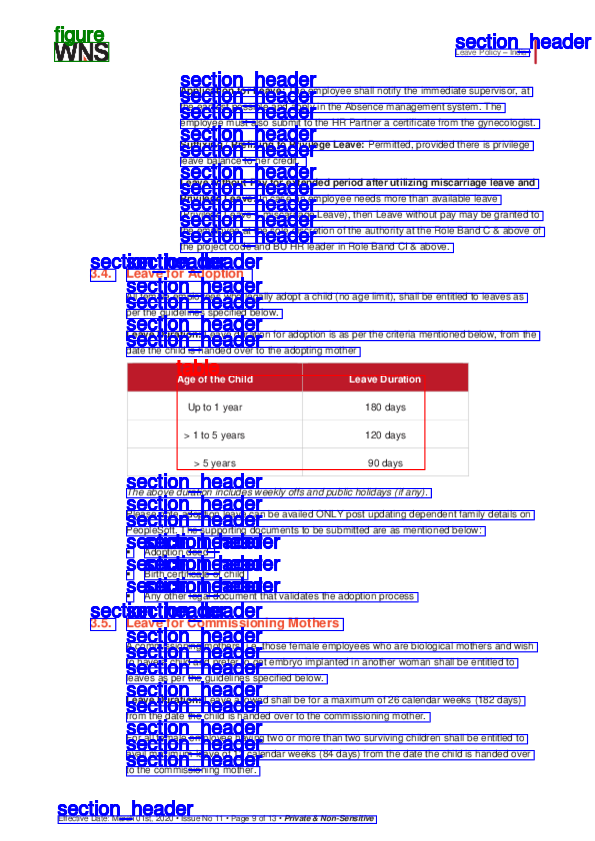

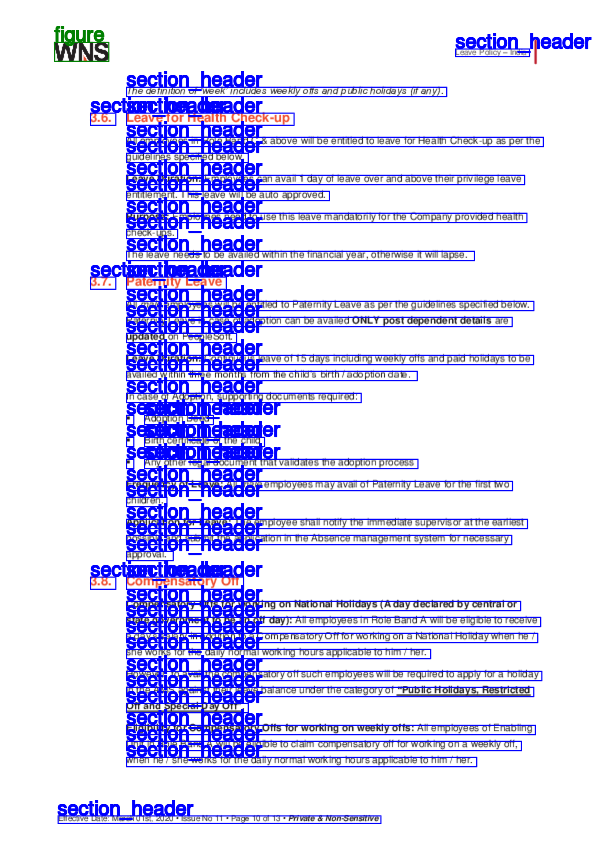

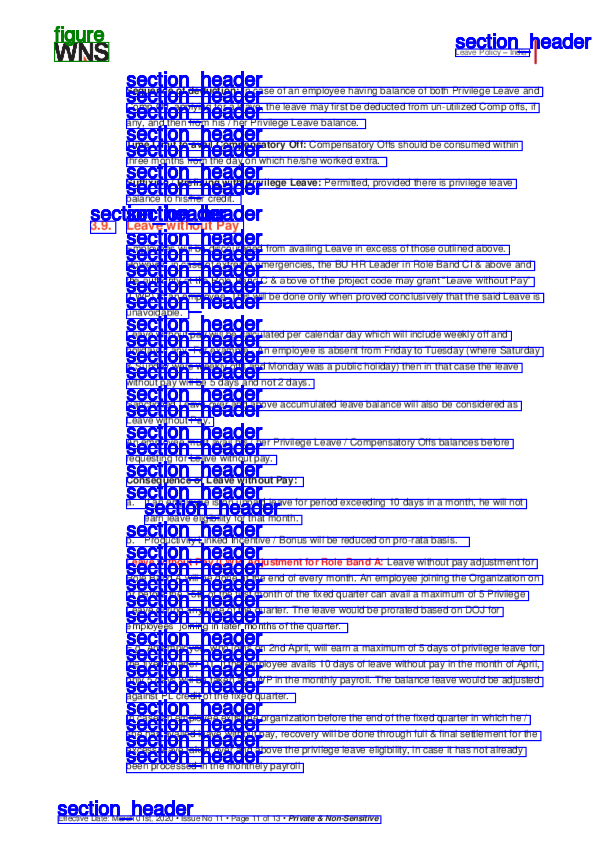

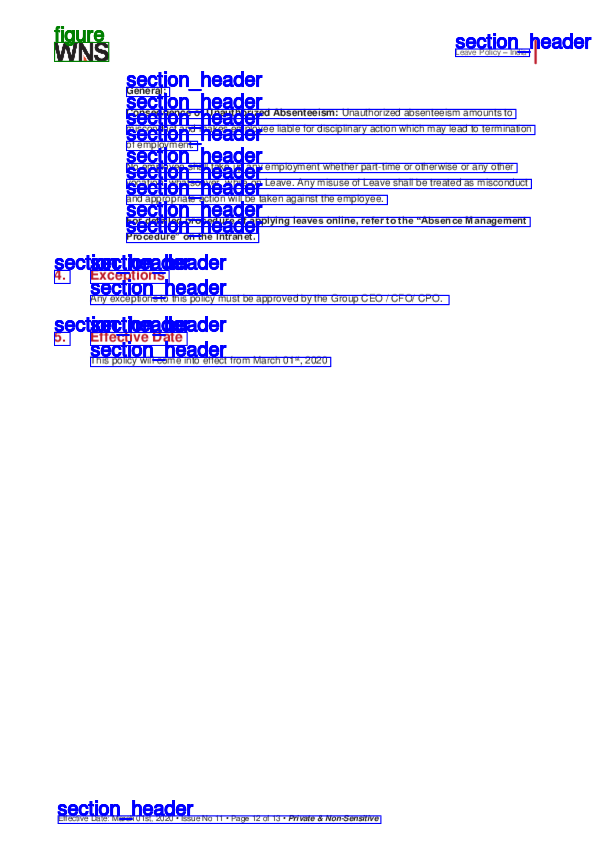

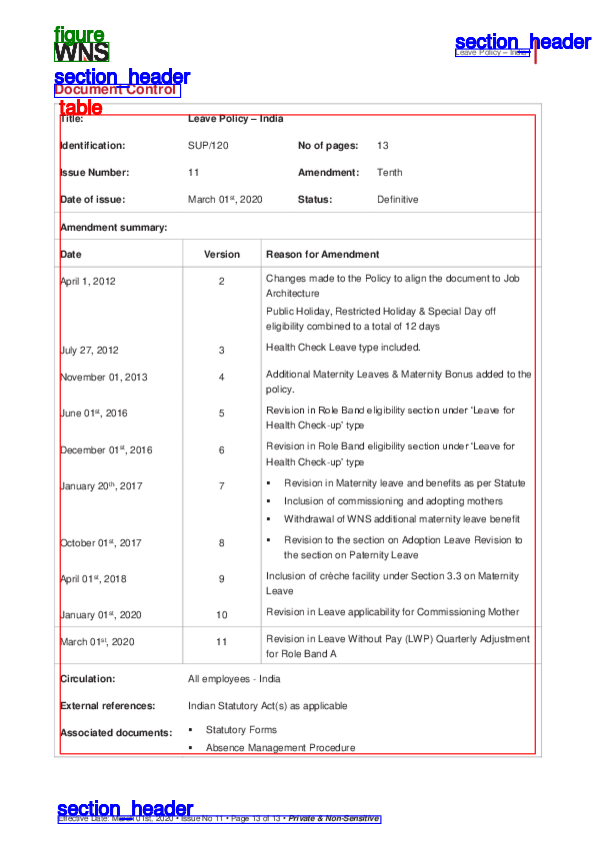

In [2]:
import pdftotree

path = '/Users/vivek/flutter_apps/skipping/backend/media/34962b79-3ed8-49f5-a6d7-cbb639d4065a.pdf'
pdftotree.parse(pdf_file=path, html_path='temp.html',visualize=True)


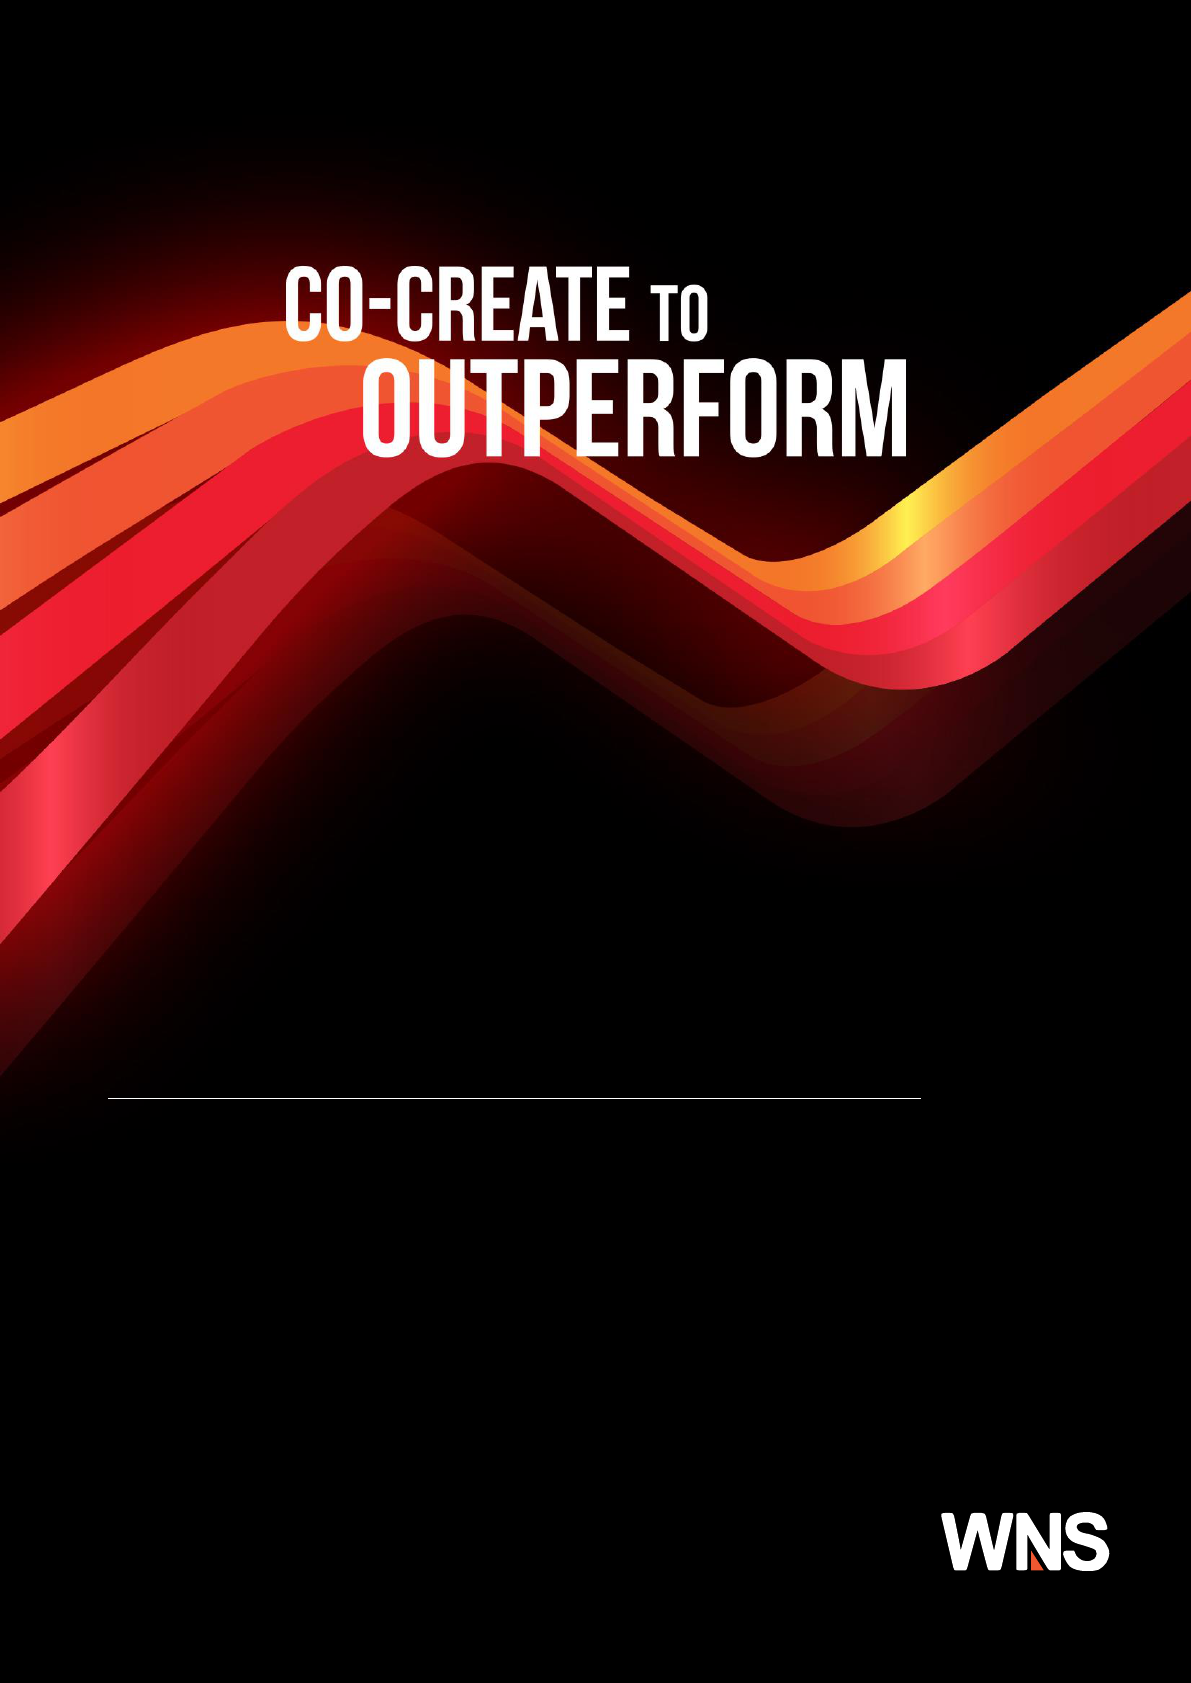
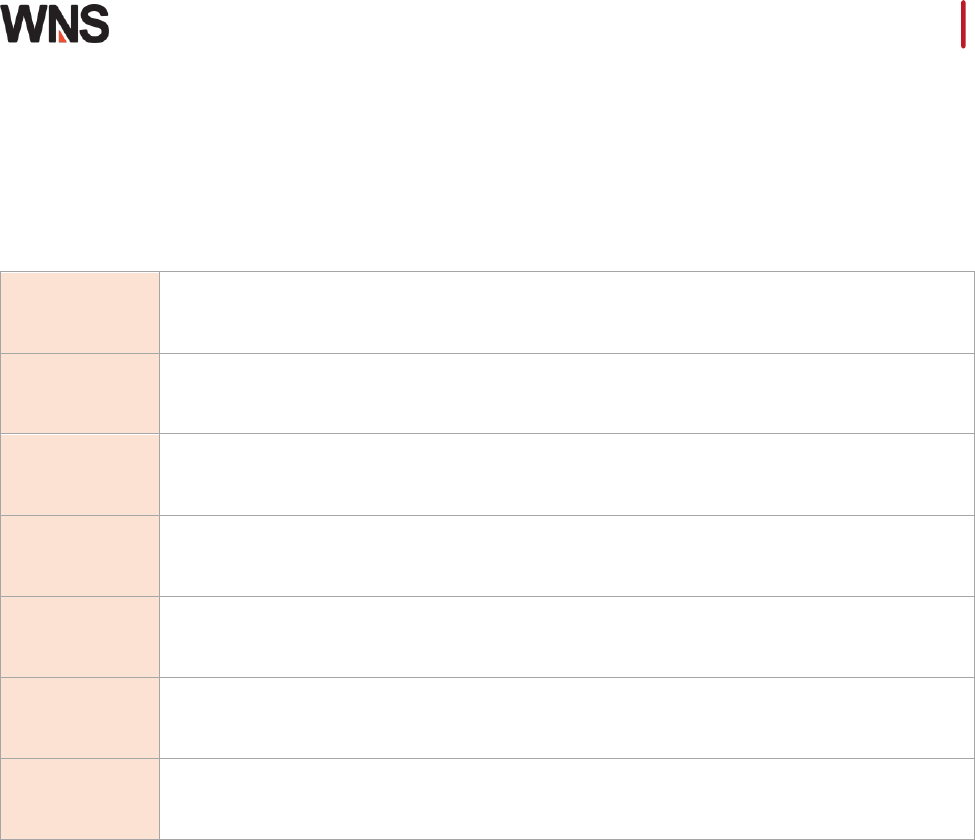
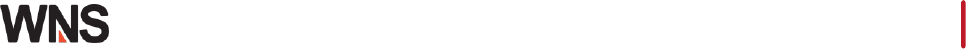
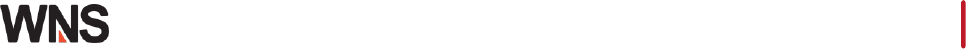
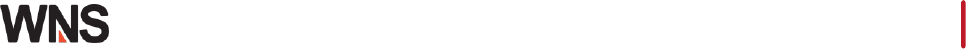
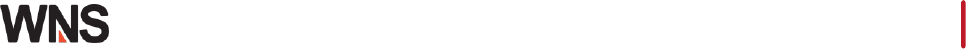
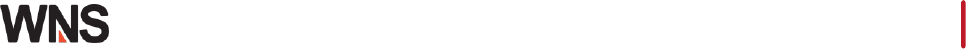
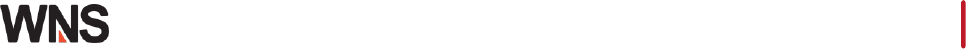
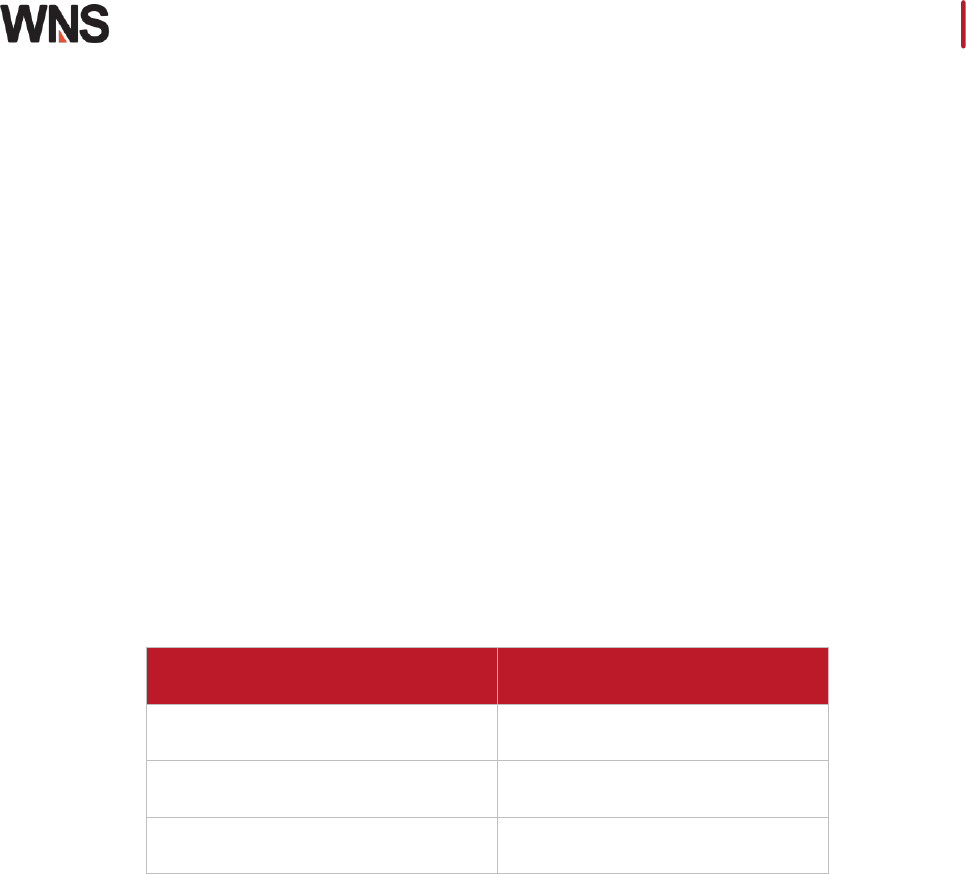
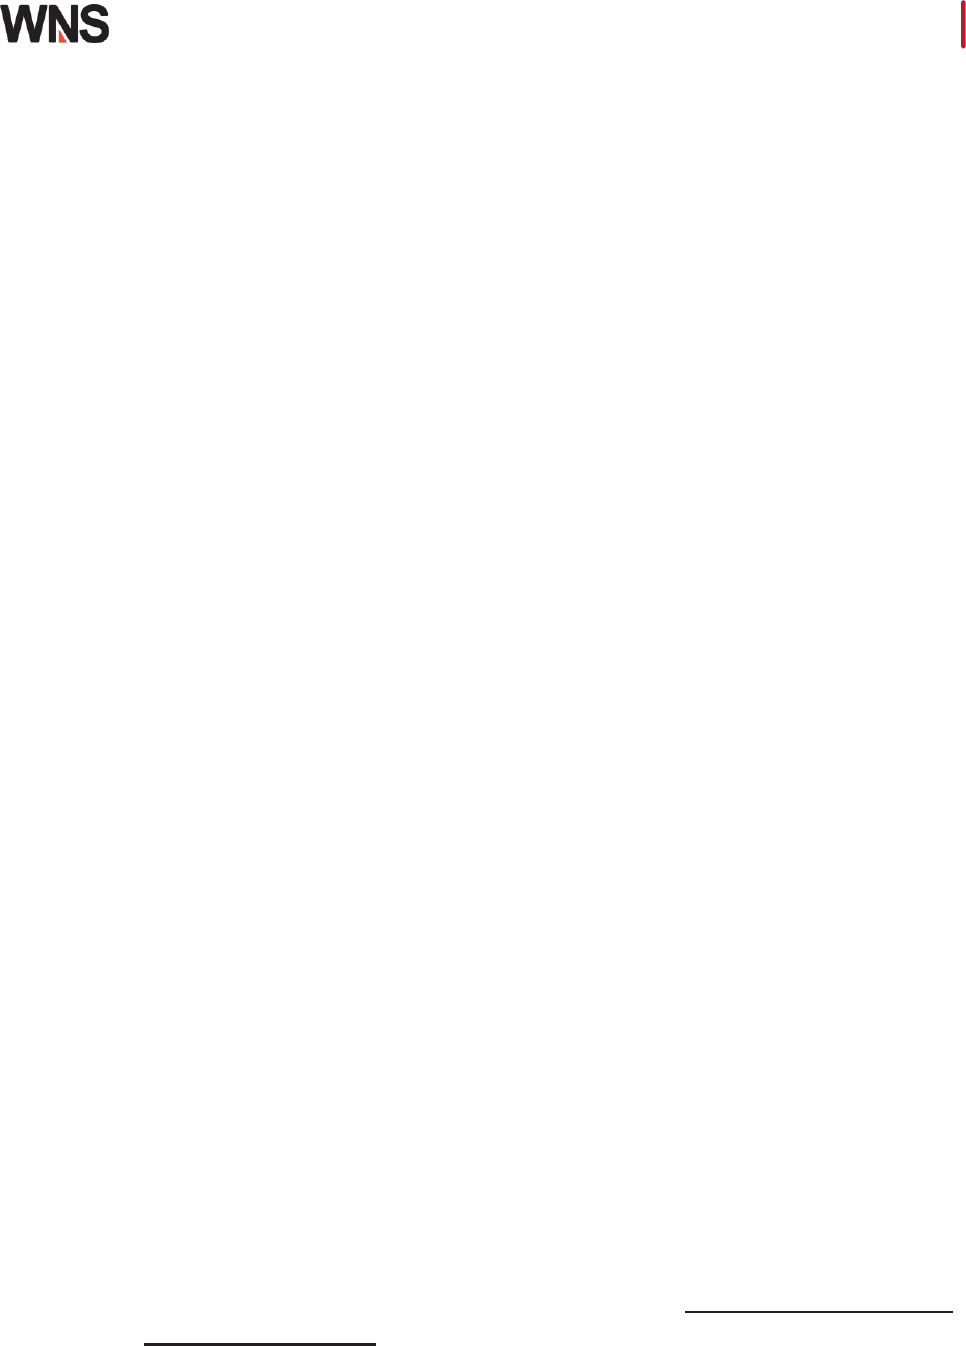
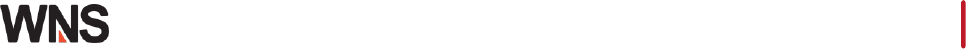
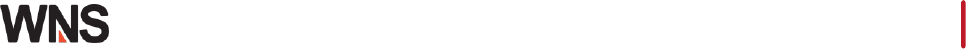
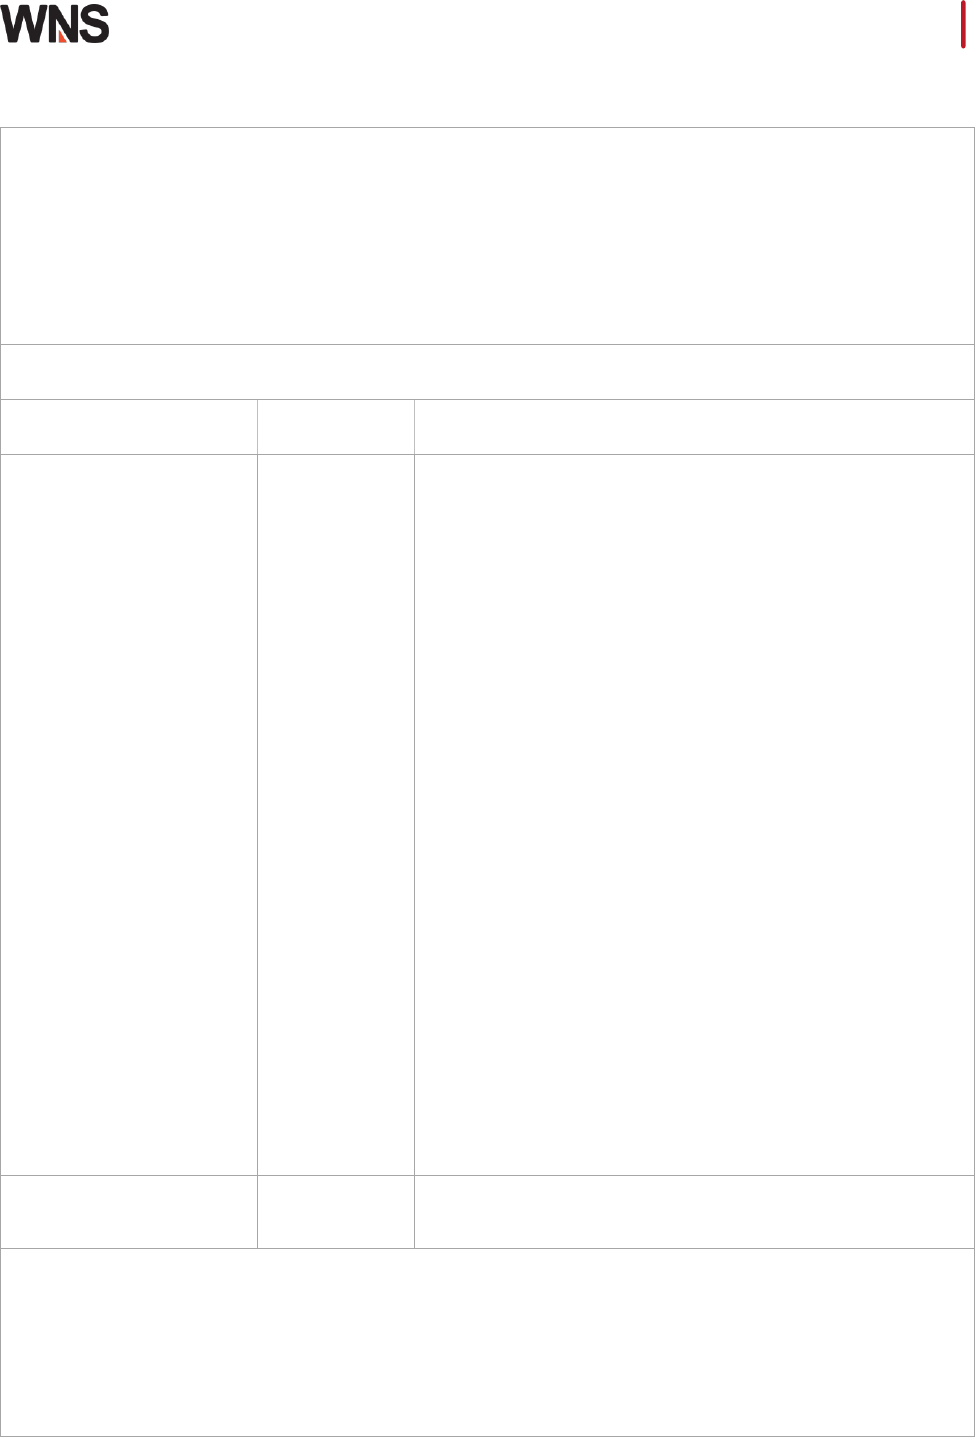
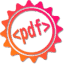

In [5]:
from IPython.display import HTML

HTML(filename="./temp.html", )

In [11]:
!git clone https://github.com/HazyResearch/pdftotree.git

Cloning into 'pdftotree'...
remote: Enumerating objects: 29, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1557 (delta 10), reused 10 (delta 5), pack-reused 1528
Receiving objects: 100% (1557/1557), 14.13 MiB | 3.64 MiB/s, done.
Resolving deltas: 100% (826/826), done.


In [4]:
!pdf2htmlex {path} temp.html

Preprocessing: 13/13
Lookup 'mark' Mark Positioning lookup 8 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 7 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 1 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 0 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 8 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Posit

In [8]:
from nltk import sent_tokenize
text = """JavaScript is one of the most popular languages for writing web and mobile applications today. The\nlanguage facilitates fast prototyping of ideas via dynamic typing. The runtime provides the means\nfor fast iteration on those ideas via dynamic compilation. This fuels a fast edit-refresh cycle, which\npromises an immersive coding experience that is quite appealing to creative developers.\nHowever, evolving and growing a JavaScript codebase is notoriously challenging. Developers\nspend a lot of time debugging silly mistakes—like mistyped property names, out-of-order arguments,\nreferences to missing values, checks that never fail due to implicit conversions, and so on—and\nworse, unraveling assumptions and guarantees in code written by others. In many other languages,\nthis overhead is mitigated by having a layer of types over the code and building tools for the\ndeveloper that use type information. For example, types can be used to identify common bugs andto document interfaces of libraries. Our aim is to bring such type-based tooling to JavaScript."""
for sent in sent_tokenize(text):
    print(sent)
    print("****")

JavaScript is one of the most popular languages for writing web and mobile applications today.
****
The
language facilitates fast prototyping of ideas via dynamic typing.
****
The runtime provides the means
for fast iteration on those ideas via dynamic compilation.
****
This fuels a fast edit-refresh cycle, which
promises an immersive coding experience that is quite appealing to creative developers.
****
However, evolving and growing a JavaScript codebase is notoriously challenging.
****
Developers
spend a lot of time debugging silly mistakes—like mistyped property names, out-of-order arguments,
references to missing values, checks that never fail due to implicit conversions, and so on—and
worse, unraveling assumptions and guarantees in code written by others.
****
In many other languages,
this overhead is mitigated by having a layer of types over the code and building tools for the
developer that use type information.
****
For example, types can be used to identify common bugs andto d

In [72]:
from nltk import sent_tokenize
sentences = [] 
current_line = ""
current_index = []
k = 5 
stride = 2

all_lines = item.parsed_data['pages']['5']['lines']
for idx, line in  enumerate(all_lines): 
    text =  line["text"].replace("\n", " ")
    temp = sent_tokenize(text)
    if len(temp) == 0: 
        continue
    if len(temp) == 1:
        current_line += text + " "
        current_index.append(idx)
    else:
        current_line += temp[0] 
        current_index.append(idx)
        sentences.append({"text": current_line, "line_index": current_index})
        
        for i in temp[1: -1]:
            sentences.append({"text": i, "line_index": [idx]})
        current_line = temp[-1] + " "
        current_index = [idx]
    
if current_line:
    sentences.append({"text": current_line, "line_index": current_index})

contexts = [] 
for idx in range(0, max(len(sentences) - k, 1), stride): 
    valid_sentences = sentences[idx: idx + k]
    context = {"text" : " ".join([i["text"] for i in valid_sentences])}
    line_idx = [] 
    for i in valid_sentences: 
        line_idx.extend(i['line_index'])
    context["rects"] = [{'y0': all_lines[i]['y0'], 
                         'y1': all_lines[i]['y1'], 
                         'x0': all_lines[i]['x0'], 
                         'x1': all_lines[i]['x1'], 
                         'top': all_lines[i]['top']} for i in line_idx]
    contexts.append(context)

In [126]:

# Taken from here
# https://www.blog.pythonlibrary.org/2018/05/03/exporting-data-from-pdfs-with-python/
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import StringIO
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter, XMLConverter, HTMLConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
from io import BytesIO
import pdfplumber

def extract_text(path):
    rsrcmgr = PDFResourceManager()
    retstr = StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos=set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                    password=password,caching=caching,
                                    check_extractable=False):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text.split("\n")


def convert_pdf(path, format='text', codec='utf-8', password=''):
    rsrcmgr = PDFResourceManager()
    retstr = BytesIO()
    laparams = LAParams(char_margin=20)
    if format == 'text':
        device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    elif format == 'html':
        device = HTMLConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    elif format == 'xml':
        device = XMLConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    else:
        raise ValueError('provide format, either text, html or xml!')
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    maxpages = 0
    caching = True
    pagenos=set()
    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages, password=password,caching=caching, check_extractable=False):
        interpreter.process_page(page)

    text = retstr.getvalue().decode()
    fp.close()
    device.close()
    retstr.close()
    return text

In [181]:
path = '/Users/vivek/flutter_apps/skipping/backend/media/34962b79-3ed8-49f5-a6d7-cbb639d4065a.pdf'
# path = '/Users/vivek/Downloads/compressed.tracemonkey-pldi-09.pdf'
import tempfile
import os 
import subprocess 
import shutil
def convert_pdf_to_html(pdf_file, opts=None):
    tmpdir = tempfile.mkdtemp(prefix='pdf2html-')
    xml_data = ''
    try:
        xml_file = os.path.join(tmpdir, 'data') # pdf2html always adds .xml
        subprocess.check_call(['pdftohtml', '-hidden', '-nodrm', '-c', '-xml',
                               pdf_file, xml_file])
        xml_file += '.xml'
        xml_data = open(xml_file).read()
    finally:
            shutil.rmtree(tmpdir)
    return xml_data

xml = convert_pdf_to_html(path)
root = ET.fromstring(xml)
pages = root.findall('page')

def _get_text(item): 
    data = {'text': item.text or ""} 
    for key in item.attrib:
        data[key] = item.attrib[key]
    for item in item.iter(): 
        if item.tag == 'b': 
            data['bold'] = True
            data['text'] = item.text
        if item.tag == 'i': 
            data['italics']  = True
            data['text'] = item.text
        if item.tag == 'text': 
            data['text'] = item.text or data.get('text')
    return data

all_lines = [] 
for page_num, page in enumerate(pages): 

    page_object = {"page": page_num + 1 , "width": width, "height": height} 
    lines = root.findall('page[@number=\'{}\']/text'.format(page_num+1)) 
    print("{} Number of Lines in Page {}".format(len(lines), page_num))

    for box in lines: 
        temp = _get_text(box)
        temp['page'] = page_num
        all_lines.append(temp)


11 Number of Lines in Page 0
35 Number of Lines in Page 1
72 Number of Lines in Page 2
66 Number of Lines in Page 3
69 Number of Lines in Page 4
60 Number of Lines in Page 5
60 Number of Lines in Page 6
62 Number of Lines in Page 7
61 Number of Lines in Page 8
71 Number of Lines in Page 9
55 Number of Lines in Page 10
32 Number of Lines in Page 11
115 Number of Lines in Page 12


In [196]:
sentences = [] 
current_line = ""
current_index = []
current_blank = 0 
for idx, line in  enumerate(all_lines): 
    text =  line["text"].replace("\n", " ")
    temp = sent_tokenize(text)
    if text.strip() == "": 
        current_blank += 1
    if current_blank == 3: 
        sentences.append({"text": current_line, "line_index": current_index})
        current_line = ""
        current_index = []
        current_blank = 0 
        continue
    if len(temp) == 0: 
        continue
    if len(temp) == 1:
        current_line += text + " "
        current_index.append(idx)
    else:
        current_line += temp[0] 
        current_index.append(idx)
        sentences.append({"text": current_line, "line_index": current_index})
        
        for i in temp[1: -1]:
            sentences.append({"text": i, "line_index": [idx]})
        current_line = temp[-1] + " "
        current_index = [idx]
        current_blank = 0 

contexts = [] 
for idx in range(0, max(len(sentences) - k, 1), stride): 
    valid_sentences = sentences[idx: idx + k]
    context = {"text" : " ".join([i["text"] for i in valid_sentences])}
    line_idx = [] 
    for i in valid_sentences: 
        line_idx.extend(i['line_index'])
    context["rects"] = [{'height': all_lines[i]['height'], 
                         'width': all_lines[i]['width'], 
                         'left': all_lines[i]['left'], 
                         'top': all_lines[i]['top'],
                         'page': all_lines[i]['page'],
                         
                        } for i in line_idx]
    contexts.append(context)

In [197]:
contexts

[{'text': 'Effective Date: March 01st, 2020  • Issue No 11 • Page 1 of 13 •  Private & Non-Sensitive  Leave Policy  – India  March 01 st , 2020  Leave Policy  – India  Effective Date: March 01st, 2020  • Issue No 11 • Page 2 of 13 •  Private & Non-Sensitive  Synopsis  The purpose of this policy is to provide a leave management framework for employees of WNS Global  Services Pvt. Ltd. Reference  SUP/ 120  Status  Definitive  Author  Compensation and Benefits Team  Authorized  Head  – Compensation and Benefits  Approved  CEO’s Office  Approved  CPO  Approved  Director  – WNS Global Services Private Limited  ',
  'rects': [{'height': '11',
    'width': '178',
    'left': '86',
    'top': '1223',
    'page': 0},
   {'height': '13', 'width': '161', 'left': '264', 'top': '1221', 'page': 0},
   {'height': '11', 'width': '135', 'left': '425', 'top': '1223', 'page': 0},
   {'height': '28', 'width': '179', 'left': '92', 'top': '788', 'page': 0},
   {'height': '34', 'width': '98', 'left': '270', 

In [113]:
!pdf2htmlex /Users/vivek/flutter_apps/skipping/backend/media/34962b79-3ed8-49f5-a6d7-cbb639d4065a.pdf temp.html

Preprocessing: 13/13
Lookup 'mark' Mark Positioning lookup 8 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 7 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 1 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 0 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Positioning lookup 8 has an
offset bigger than 65535 bytes. This means
FontForge must use an extension lookup to output it.
Not all applications support extension lookups.
Lookup 'mark' Mark Posit

In [140]:
!pdftohtml {path} -c -xml temp2.xml

Page-1
Page-2
 link to page 4  link to page 4  link to page 4  link to page 4  link to page 5  link to page 7  link to page 9  link to page 9  link to page 10  link to page 10  link to page 10  link to page 11  link to page 12  link to page 12  link to page 13 Page-3
Page-4
Page-5
Page-6
Page-7
Page-8
Page-9
Page-10
Page-11
Page-12
Page-13


In [132]:
!ls -lh

total 25304
-rw-r--r--    1 vivek  staff   7.0M 30 Jan 17:34 Search Experiments.ipynb
-rw-r--r--    1 vivek  staff   947K 25 Jan 13:43 TV_CL_API_Agr_-_with_Forms_v_2016_09_26.docx.pdf
drwxr-xr-x    5 vivek  staff   160B 22 Jan 19:48 __pycache__
drwxr-xr-x   19 vivek  staff   608B 30 Jan 08:09 core
drwxr-xr-x   11 vivek  staff   352B 30 Jan 06:47 data
drwxr-xr-x    6 vivek  staff   192B 22 Jan 19:33 env
drwxr-xr-x    9 vivek  staff   288B 25 Jan 13:47 experiments
-rwxr-xr-x    1 vivek  staff   631B 23 Jan 10:39 manage.py
drwxr-xr-x  317 vivek  staff   9.9K 30 Jan 08:48 media
drwxr-xr-x   14 vivek  staff   448B 28 Jan 08:38 pdftotree
-rw-r--r--    1 vivek  staff   285B 22 Jan 19:44 requirements.txt
-rw-r--r--    1 vivek  staff   1.3M 15 Sep  2007 ta-lib-0.4.0-src.tar.gz
-rw-r--r--    1 vivek  staff   1.9M 30 Jan 17:21 temp.html
-rw-r--r--    1 vivek  staff   3.1K 30 Jan 17:34 temp2-10_1.png
-rw-r--r--    1 vivek  staff   3.1K 30 Jan 17:34 temp2-11_1.png
-rw-r--r--    1 vivek  staff   3.1

In [199]:
!rm -r *png
